In [24]:
import struct
from itertools import product
from math import floor
from os import linesep
from pathlib import Path
from collections import namedtuple

import gdal
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

gdal.AllRegister()

In [25]:
base_dir = Path.home() / "dev" / "malarial_communities"
landscan_file = base_dir / "data" / "LandScan Global 2017" / "lspop2017"

if not landscan_file.exists():
    print(f"The given file doesn't exist: {landscan_file}")
dataset = gdal.Open(str(landscan_file), gdal.GA_ReadOnly)
if not dataset:
    print(f"Could not open {landscan_file}.")
    
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
    

Driver: AIG/Arc/Info Binary Grid
Size is 43200 x 21600 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
Origin = (-180.0, 89.99999999999929)
Pixel Size = (0.0083333333333333, -0.0083333333333333)


In [26]:
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

band_minimum = band.GetMinimum()
band_maximum = band.GetMaximum()
if not band_minimum or not band_maximum:
    (band_minimum,band_maximum) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(band_minimum,band_maximum))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))


Band Type=Int32
Min=0.000, Max=168386.000


In [27]:
scanline = band.ReadRaster(xoff=0, yoff=1000,
                        xsize=band.XSize, ysize=1,
                        buf_xsize=band.XSize, buf_ysize=1,
                        buf_type=gdal.GDT_Int32)
np_floats = np.frombuffer(scanline, dtype=np.int32)
tuple_of_floats = struct.unpack("i" * band.XSize, scanline)
for (a, b) in zip(np_floats, tuple_of_floats):
    assert a == b
print(len(tuple_of_floats))
print(type(tuple_of_floats))
print(min(np_floats))
print(max(np_floats))

43200
<class 'tuple'>
-2147483647
0


In [28]:
print(np_floats[:10])


[-2147483647 -2147483647 -2147483647 -2147483647 -2147483647 -2147483647
 -2147483647 -2147483647 -2147483647 -2147483647]


In [29]:
def make_histogram(band, bin_count=200):
    histogram_range = (band.GetMinimum(), band.GetMaximum())
    histogram = None
    edges = None
    for y_offset in range(band.YSize):
        scanline_buffer = band.ReadRaster(
            xoff=0, yoff=y_offset, xsize=band.XSize, ysize=1,
            buf_xsize=band.XSize, buf_ysize=1, buf_type=gdal.GDT_Int32,
        )
        scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
        line_histogram, edges = np.histogram(scanline, bins=bin_count, range=histogram_range, density=False)
        if histogram is not None:
            histogram += line_histogram
        else:
            histogram = line_histogram

    return histogram, edges

hist, edges = make_histogram(band, bin_count=200)

In [30]:
print("Gigabytes of data")
print(hist.sum() * 4 / 1024**3)


Gigabytes of data
1.1848197393119335


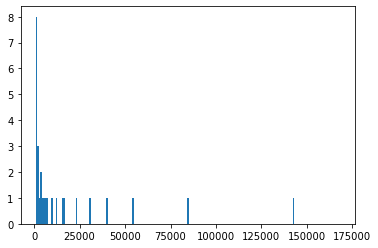

In [31]:

def pixel_containing(point, geo_transform):
    return [
        int(floor(1.0 / geo_transform[1]) * (point[0] - geo_transform[0])),
        int(floor(1.0 / geo_transform[5]) * (point[1] - geo_transform[3])),
    ]

plt.hist(hist[1:], bins=edges[1:])

LongLat = namedtuple("LongLat", "long lat")

africa_corners = [LongLat(-20, -40), LongLat(55, 40)]

kampala = LongLat(0 + 18 / 60, 32 + 34 / 60)
moroto = LongLat(2 + 31 / 60, 34 + 40 / 60)


def pixel_corners_of_longlat_box(corners, geo_transform):
    """
    
    :param corners: Lowerleft and upper-right 
    :param geo_transform: vector length 6 from GDAL.
    :return: 
    """
    longlat_corners = [
        [corners[a].long, corners[b].lat]
        for (a, b) in [[0, 0], [0, 1], [1, 0], [1, 1]]
    ]
    
    corner_pixels = [pixel_containing(corner, geo_transform) for corner in longlat_corners]
    longitude_range = [
        min([x[0] for x in corner_pixels]),
        max([x[0] for x in corner_pixels]),
    ]
    latitude_range = [
        min([x[1] for x in corner_pixels]),
        max([x[1] for x in corner_pixels]),
    ]
    # This is a pair of longitudes and a pair of latitudes.
    return LongLat(longitude_range, latitude_range)


africa_pixel_range = pixel_corners_of_longlat_box(africa_corners, geotransform)
# Just a chunk of Uganda.
uganda_pixel_range = pixel_corners_of_longlat_box([kampala, moroto], geotransform)


In [34]:
def band_as_numpy(band):
    scanline_buffer = band.ReadRaster(
        xoff=0, yoff=0, xsize=band.XSize, ysize=band.YSize,
        buf_xsize=band.XSize, buf_ysize=band.YSize, buf_type=gdal.GDT_Int32,
    )
    scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
    return np.reshape(scanline, (band.XSize, band.YSize))


def sub_band_as_numpy(band, y_limits):
    """Read subsets of the dataset so that we don't hold the whole thing
    in memory. It seems wasteful to reread parts, but GDAL keeps its own cache.
    """
    y_size = y_limits[1] - y_limits[0]
    scanline_buffer = band.ReadRaster(
        xoff=0,
        yoff=y_limits[0],
        xsize=band.XSize,
        ysize=y_size,
        buf_xsize=band.XSize,
        buf_ysize=y_size,
        buf_type=gdal.GDT_Int32,
    )
    scanline = np.frombuffer(scanline_buffer, dtype=np.int32)
    return np.reshape(scanline, (band.XSize, y_size))


def largest_within_distance(band, distance, bounding_box_pixels=None):
    """
    Find the largest pixel within the given distance.
    """
    dx2 = distance**2
    value_range = (int(band.GetMinimum()), int(band.GetMaximum()))
    maximum_distance = max(band.XSize, band.YSize)**2
    peaks = list()
    not_a_peak = 0
    if not bounding_box_pixels:
        bounding_box_pixels = LongLat([0, band.XSize], [0, band.YSize])
    for j in range(*bounding_box_pixels.lat):
        print(f"{j} ", end="")
        y_limits = (max(0, j - distance), min(band.YSize, j + distance + 1))
        map_j = j - y_limits[0]
        map = sub_band_as_numpy(band, y_limits)
        for i in range(*bounding_box_pixels.long):
            if map[i, map_j] < value_range[0] + 1:
                continue
            x_limits = (max(0, i - distance), min(band.XSize, i + distance + 1))
            minimum_distance = maximum_distance
            for (x, y) in product(range(*x_limits), range(map.shape[1])):
                if map[x, y] > map[i, map_j]:
                    minimum_distance = min(minimum_distance, (x - i)**2 + (y - map_j)**2)
            if minimum_distance > dx2 and minimum_distance < maximum_distance:
                peaks.append((minimum_distance, i, j))
            else:
                not_a_peak += 1
    print(f"{linesep}Found {len(peaks)} and discarded {not_a_peak}.")
    peaks.sort()
    return peaks

p = largest_within_distance(band, 20, uganda_pixel_range)

6695 6696 6697 6698 6699 6700 6701 6702 6703 6704 6705 6706 6707 6708 6709 6710 6711 6712 6713 6714 6715 6716 6717 6718 6719 6720 6721 6722 6723 6724 6725 6726 6727 6728 6729 6730 6731 6732 6733 6734 6735 6736 6737 6738 6739 6740 6741 6742 6743 6744 6745 6746 6747 6748 6749 6750 6751 6752 6753 6754 6755 6756 6757 6758 6759 6760 6761 6762 6763 6764 6765 6766 6767 6768 6769 6770 6771 6772 6773 6774 6775 6776 6777 6778 6779 6780 6781 6782 6783 6784 6785 6786 6787 6788 6789 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893 6894 

In [33]:
print(np.array(p).shape)

(33, 3)
